In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the final dataset from Google Drive
final_data_path = "/content/drive/My Drive/final_data.csv"
final_data = pd.read_csv(final_data_path)

# Display the first few rows to verify
print("Final dataset preview:")
print(final_data.head())

Mounted at /content/drive
Final dataset preview:
   Unnamed: 0        date       date2           file language  length  \
0           1  2000-01-06  2000-01-06    SPEECH_00_1  ENGLISH    2344   
1           2  2000-01-19  2000-01-19   SPEECH_00_10  ENGLISH    1073   
2           3  2000-03-27  2000-03-27  SPEECH_00_100  ENGLISH    1558   
3           4  2000-03-27  2000-03-27  SPEECH_00_101  ENGLISH    3833   
4           5  2000-03-27  2000-03-27  SPEECH_00_102  ENGLISH    2624   

     month      speaker.name  \
0  2000-01    Erkki Liikanen   
1  2000-01      Neil Kinnock   
2  2000-03  Frits Bolkestein   
3  2000-03  Frits Bolkestein   
4  2000-03      Poul Nielson   

                                               title  \
0  Erkki LIIKANEN   Member of the European Commis...   
1  Neil Kinnock   Vice-President for Administrati...   
2  Frits Bolkestein   Member of the European Comm...   
3  Frits Bolkestein   Member of the European Comm...   
4  Speech by Mr Poul Nielson   European

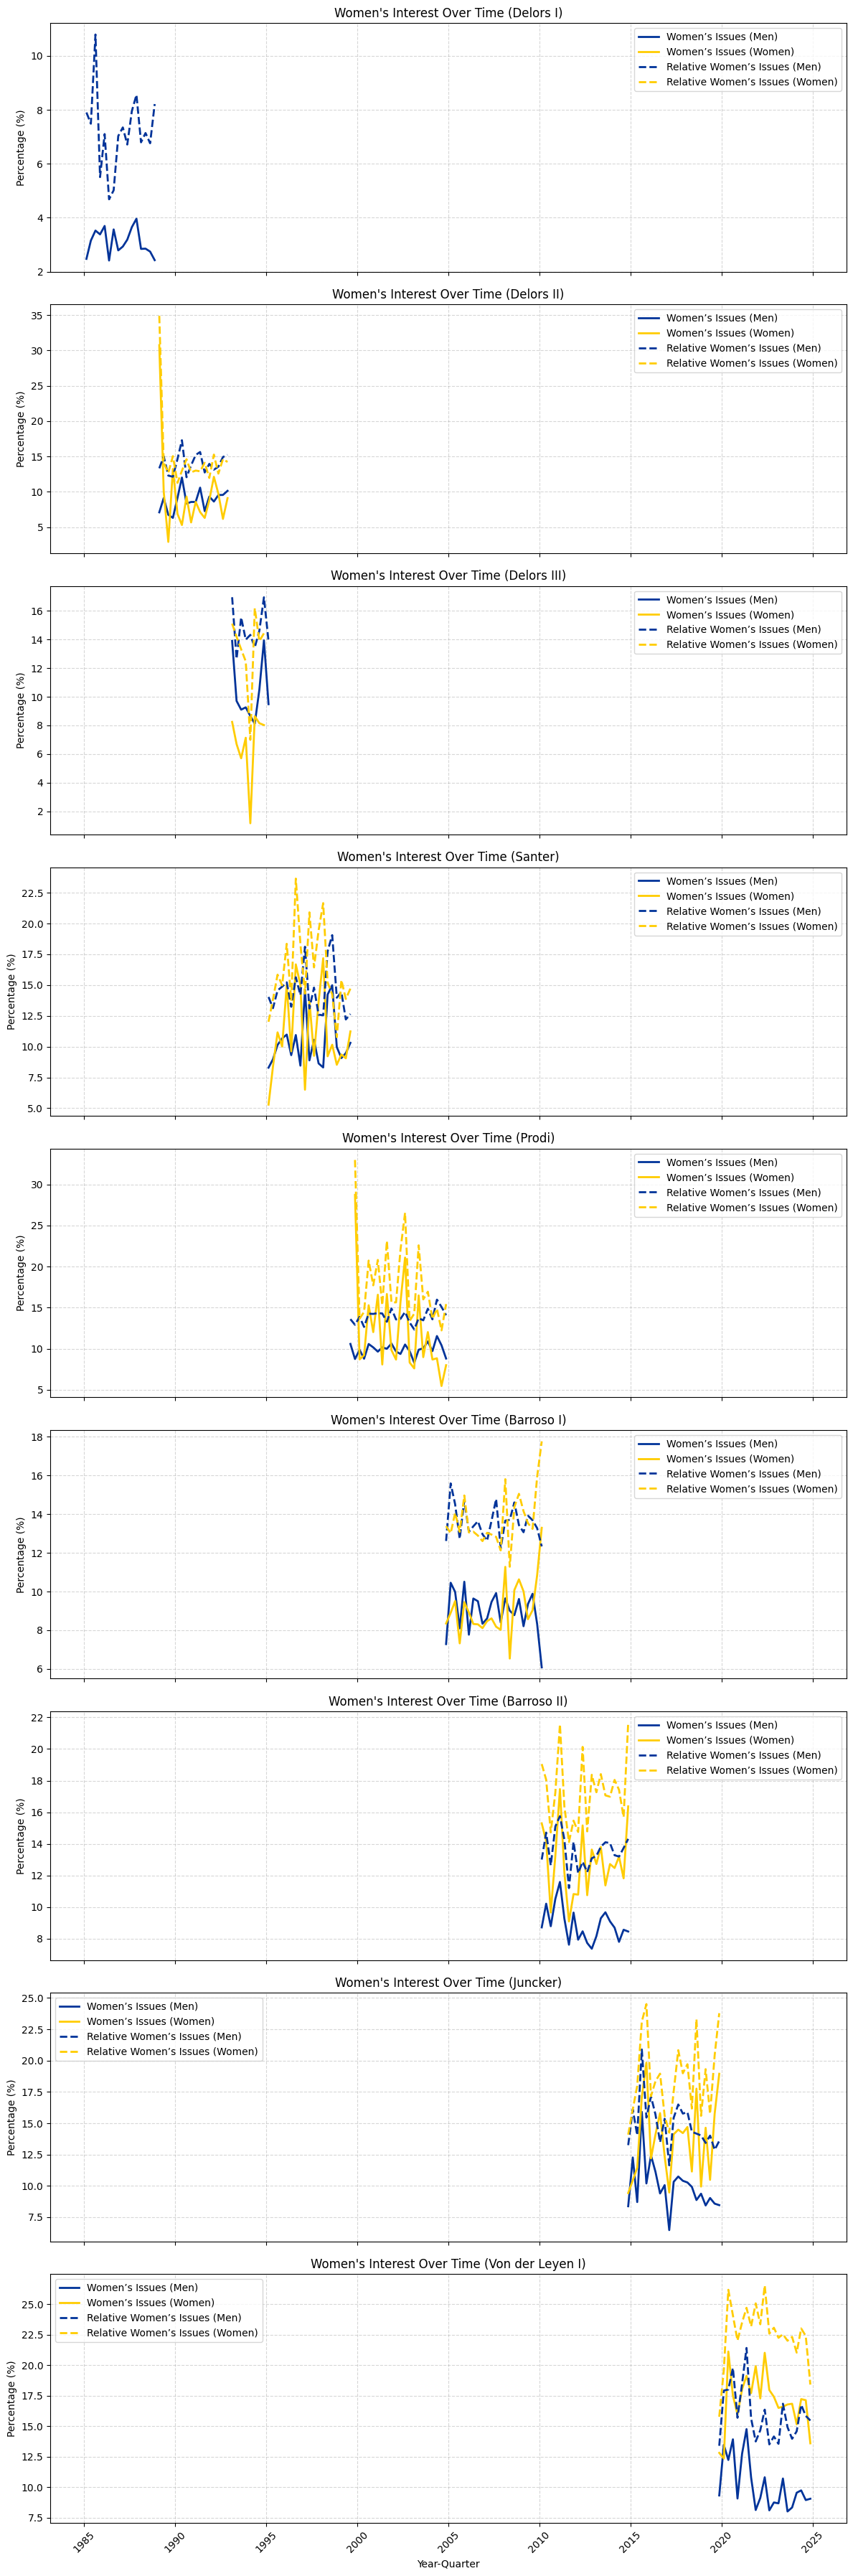

Plot saved as vector graphic at: /content/drive/My Drive/phd plots/women_interest_by_commission_quarters.svg


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import os

# Ensure date column is in datetime format
final_data['date'] = pd.to_datetime(final_data['date'], errors='coerce')

# Ensure necessary columns exist
required_cols = ['Sex_speakerinfo', 'Commission_speakerinfo', 'date', 'w_top_tot', 'w_top_rel']
for col in required_cols:
    if col not in final_data.columns:
        raise KeyError(f"Column '{col}' is missing from the dataset.")

# **Aggregate values per quarter, sex, and commission**
final_data['year_quarter'] = final_data['date'].dt.to_period("Q")  # Convert to quarterly periods

aggregated_data = final_data.groupby(['year_quarter', 'Commission_speakerinfo', 'Sex_speakerinfo'])[['w_top_tot', 'w_top_rel']].mean().reset_index()

# Convert year-quarter to datetime for plotting (middle of each quarter for proper ordering)
aggregated_data['year_quarter'] = aggregated_data['year_quarter'].astype(str)
aggregated_data['date'] = pd.to_datetime(aggregated_data['year_quarter'].apply(lambda x: f"{x[:4]}-{int(x[-1])*3-1}-15"))

# **Create separate plots for each Commission_speakerinfo**
commissions = aggregated_data['Commission_speakerinfo'].unique()

# **Set up multiple plots**
fig, axes = plt.subplots(len(commissions), 1, figsize=(12, len(commissions) * 4), sharex=True)

if len(commissions) == 1:
    axes = [axes]  # Ensure axes is iterable for a single Commission case

for ax, commission in zip(axes, commissions):
    data_subset = aggregated_data[aggregated_data['Commission_speakerinfo'] == commission]

    # Split by Sex
    data_men = data_subset[data_subset['Sex_speakerinfo'] == 0]
    data_women = data_subset[data_subset['Sex_speakerinfo'] == 1]

    # **Plot Women's Interest Percentage Over Time**
    ax.plot(data_men['date'], data_men['w_top_tot'], color="#003399", linestyle='-', linewidth=2, label="Women’s Issues (Men)")
    ax.plot(data_women['date'], data_women['w_top_tot'], color="#FFCC00", linestyle='-', linewidth=2, label="Women’s Issues (Women)")

    # **Plot Relative Women's Interest Over Time**
    ax.plot(data_men['date'], data_men['w_top_rel'], color="#003399", linestyle='--', linewidth=2, label="Relative Women’s Issues (Men)")
    ax.plot(data_women['date'], data_women['w_top_rel'], color="#FFCC00", linestyle='--', linewidth=2, label="Relative Women’s Issues (Women)")

    # Formatting
    ax.set_title(f"Women's Interest Over Time ({commission})")
    ax.set_ylabel("Percentage (%)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

# **Format x-axis for continuous time display**
plt.xlabel("Year-Quarter")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()

# **Save the plot as an SVG vector graphic**
save_folder = "/content/drive/My Drive/phd plots"
os.makedirs(save_folder, exist_ok=True)
save_path = os.path.join(save_folder, "women_interest_by_commission_quarters.svg")
plt.savefig(save_path, format="svg")

# Show the plot
plt.show()

print(f"Plot saved as vector graphic at: {save_path}")


In [5]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Ensure data is clean
final_data = final_data.dropna(subset=['claimbinary', 'claimcount', 'length', 'Sex_speakerinfo', 'Commission_speakerinfo', 'speaker.name'])

# Convert categorical variables
final_data['Commission_speakerinfo'] = final_data['Commission_speakerinfo'].astype("category")
final_data['speaker.name'] = final_data['speaker.name'].astype("category")

### **1️⃣ Logistic Mixed-Effects Model for claimbinary**
logit_model = smf.mixedlm("claimbinary ~ length + Sex_speakerinfo",
                          final_data,
                          groups=final_data["speaker.name"],  # Speaker-level random effects
                          re_formula="1")  # Random intercept

logit_result = logit_model.fit()

print("\n🚀 Logistic Mixed Model Results (Claim Probability):\n")
print(logit_result.summary())

### **2️⃣ Poisson GLMM for claimcount**
poisson_model = smf.mixedlm("claimcount ~ length + Sex_speakerinfo",
                             final_data,
                             groups=final_data["speaker.name"],
                             re_formula="1")  # Random intercept

poisson_result = poisson_model.fit()

print("\n🚀 Poisson Mixed Model Results (Claim Count):\n")
print(poisson_result.summary())

### **3️⃣ Check for Overdispersion in claimcount**
mean_claims = final_data['claimcount'].mean()
var_claims = final_data['claimcount'].var()

print(f"\n📊 Mean of claimcount: {mean_claims:.2f}")
print(f"📊 Variance of claimcount: {var_claims:.2f}")

if var_claims > mean_claims * 1.5:
    print("\n⚠️ Overdispersion detected! Using Negative Binomial instead of Poisson.")

    ### **4️⃣ Negative Binomial GLMM (only if overdispersion is present)**
    nb_model = smf.mixedlm("claimcount ~ length + Sex_speakerinfo",
                           final_data,
                           groups=final_data["speaker.name"],
                           re_formula="1")  # Random intercept

    nb_result = nb_model.fit()
    print("\n🚀 Negative Binomial Mixed Model Results (Claim Count):\n")
    print(nb_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



🚀 Logistic Mixed Model Results (Claim Probability):

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: claimbinary
No. Observations: 23057   Method:             REML       
No. Groups:       157     Scale:              0.0581     
Min. group size:  1       Log-Likelihood:     -116.0695  
Max. group size:  1276    Converged:          Yes        
Mean group size:  146.9                                  
---------------------------------------------------------
                 Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        0.016    0.009 1.770 0.077 -0.002  0.035
length           0.000    0.000 9.291 0.000  0.000  0.000
Sex_speakerinfo  0.062    0.016 3.940 0.000  0.031  0.093
Group Var        0.007    0.004                          


🚀 Poisson Mixed Model Results (Claim Count):

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: cl

We need a negative binominal to analyse the data -> switch to R and use brms/glmmTMB. Code is provided on GitHub.